This notebook contains our baseline model for the G1 Deep Learning Image Classification project.

**Team:** Benjamin Hunt, Rodrigo Torralba, Santiago Baron, Bianca

Over the next 3 days, we will iterate on this baseline by testing different model architectures and training setups, then compare results to understand performance trade-offs and extract key findings. Final results will be summarized in a spreadsheet and presented at the end of the project.

Loading the dataset: CIFAR-10

In [40]:
from keras.backend import clear_session  # This is to clear any previous session to prevent reusing old data from  other cells etc.
clear_session()

In [41]:
import numpy as np  # Import libraries like CIFAR-10, Numpys and pandas etc.
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [42]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # (Training set: 50,000) - (Test set: 10,000) This will remain untouched until the final evaluation.

Visualize the data : We display a few images per class to understand what the model must learn.  

<Figure size 393.701x393.701 with 0 Axes>

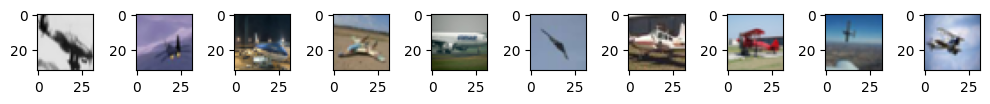

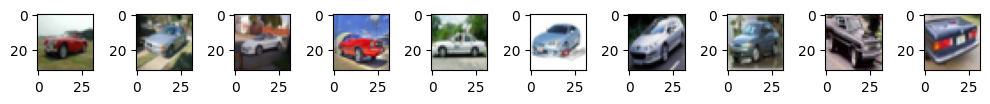

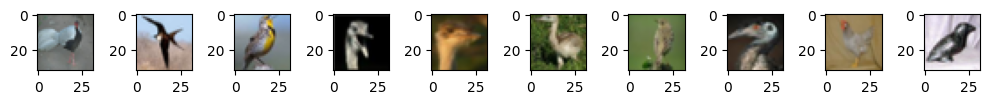

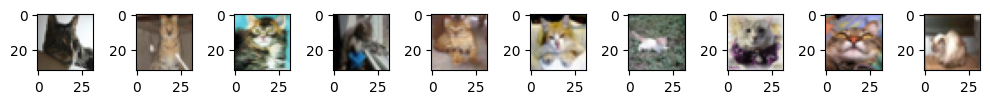

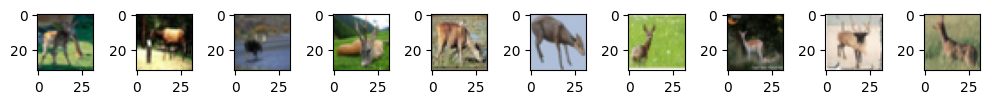

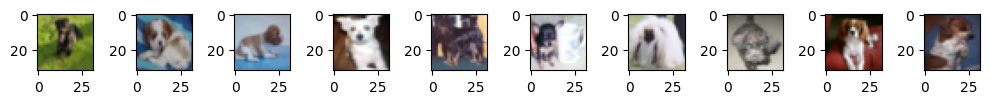

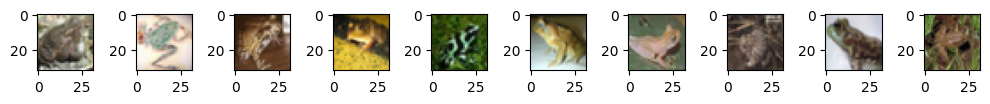

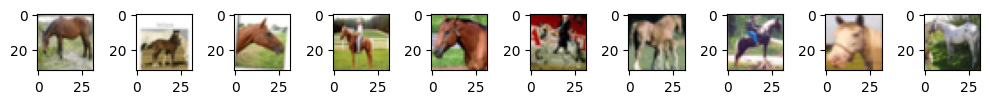

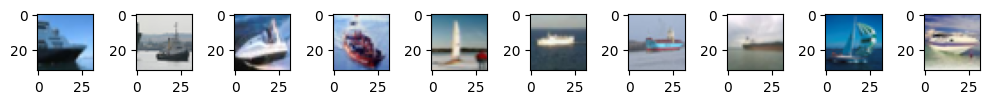

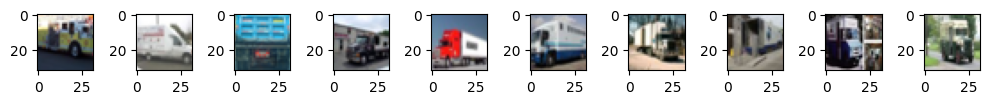

In [43]:

# print(x_train.shape) (check model shape)


num_classes = 10

fig = plt.figure(figsize=(10*1/2.54, 10*1/2.54)) # class to img plot ratio.

for idx_class in range(num_classes): # This section loops through class labels and shows sample images so we can check the dataset format and variety.

  all_idx = np.where(y_train.flatten() == idx_class)[0]

  # random selection of 10 image of each category
  rand_idx = np.random.choice(all_idx, size=10, replace=False)
  selected = x_train[rand_idx]

  plt.figure(figsize=(10, 10))

  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(selected[i])
    plt.tight_layout()

  plt.show()

Data normalization

In [44]:
x_train = x_train.astype("float32") / 255 # neural networks train more stable when they are converted to [ 0 - 1 ], here done with .astype function to normalize the code from [ 0 - 255 ].
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Prepare the labels

In [45]:
y_train = to_categorical(y_train, num_classes=10) # prepare the labels as they class from 0 - 9, this is ideal for catagorical crossentropy.
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape) # Here you casn see our train size and test size.
print(y_test.shape)

(50000, 10)
(10000, 10)


In [46]:
from sklearn.model_selection import train_test_split
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1, # explcitly remove 10% for test
    random_state=42, # random, shuffled state set before running our test.
    stratify=y_train_labels # here we create our one hot labels.
)

print("x_tr:", x_tr.shape, "x_val:", x_val.shape)
print("y_tr:", y_tr.shape, "y_val:", y_val.shape)

x_tr: (45000, 32, 32, 3) x_val: (5000, 32, 32, 3)
y_tr: (45000, 10) y_val: (5000, 10)


In [47]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

Define the first model

In [48]:
input_shape = (32, 32, 3)

model1 = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),

        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),

        layers.Dense(100, activation='relu'),
        layers.Dense(num_classes, activation="softmax")
    ]
)

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       720,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,006 (2.75 MB)

 Trainable params: 722,006 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
import time # Track time for meassure
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # prevent overfitting

# Compile the model before training
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# callbacks
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,                 # stop after 5 epochs with no val_acc improvement
    restore_best_weights=True   # revert weights to best val_acc epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)


def format_seconds(s: float) -> str:
    s = max(0.0, float(s))  # safety guard
    m, sec = divmod(s, 60)
    h, m = divmod(m, 60)
    if h >= 1:
        return f"{int(h)}h {int(m)}m {sec:.2f}s"
    if m >= 1:
        return f"{int(m)}m {sec:.2f}s"
    return f"{sec:.2f}s"



history1 = model1.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=64, verbose=1)

t1 = time.perf_counter()

fit_time = t1 - t0

print(f"Fit time (total): {format_seconds(fit_time)}")

epochs_ran = len(history1.history["loss"])
print("Fit time per epoch (avg):", format_seconds(fit_time / epochs_ran))

print("Train accuracy (last):", history1.history["accuracy"][-1])
print("Train loss (last):", history1.history["loss"][-1])

print("Val accuracy (last):", history1.history["val_accuracy"][-1])
print("Val loss (last):", history1.history["val_loss"][-1])

val_acc_best = max(history1.history["val_accuracy"])
best_epoch = 1 + history1.history["val_accuracy"].index(val_acc_best)
print("Val accuracy (best):", val_acc_best, "at epoch", best_epoch)

score = model1.evaluate(x_test, y_test, verbose=0)
print("TEST loss:", score[0])
print("TEST accuracy:", score[1])


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3529 - loss: 1.7893 - val_accuracy: 0.4826 - val_loss: 1.4438
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5429 - loss: 1.2953 - val_accuracy: 0.5708 - val_loss: 1.2299
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6002 - loss: 1.1405 - val_accuracy: 0.5844 - val_loss: 1.2011
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6362 - loss: 1.0403 - val_accuracy: 0.6228 - val_loss: 1.0881
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6602 - loss: 0.9801 - val_accuracy: 0.6342 - val_loss: 1.0519
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6856 - loss: 0.9091 - val_accuracy: 0.6362 - val_loss: 1.0607
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6996 - loss: 0.8689 - val_accuracy: 0.6524 - val_loss: 1.0291
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7171 - loss: 0.8245 - val_accuracy: 0.

Test loss: 1.254702091217041
Test accuracy: 0.6353999972343445
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


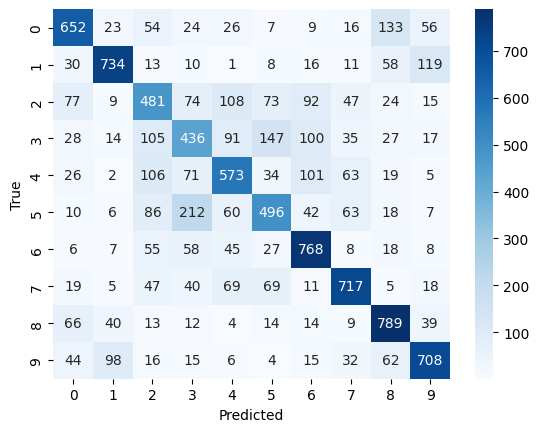

In [51]:
score = model1.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])


y_test_pred_prob = model1.predict(x_test)
y_test_pred = y_test_pred_prob.argmax(axis=1)

conf_matr = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

sns.heatmap(conf_matr, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [53]:
print(history1.history.keys())
print("Train accuracy:", history1.history["accuracy"][-1])
print("Train loss:", history1.history["loss"][-1])
print("Validation accuracy:", history1.history["val_accuracy"][-1])
print("Validation loss:", history1.history["val_loss"][-1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Train accuracy: 0.84579998254776
Train loss: 0.4471028745174408
Validation accuracy: 0.6610000133514404
Validation loss: 1.205453634262085


In [55]:
import os
print("Working directory:", os.getcwd())
print("Files here:", os.listdir())

# Save full model (best default)
model1.save("cifar10.v1_G1_cnn.keras")


Working directory: /content
Files here: ['.config', 'cifar10.v1_G1_cnn.keras', 'sample_data']


In [ ]:
# Load model syntax

# import tensorflow as tf
# model1 = tf.keras.models.load_model("model1.keras")
# print("Loaded model1.keras")
